<a href="https://colab.research.google.com/github/vitorgaboardi/network_analysis/blob/main/Wikipedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Case Study: constructing a network of wikipedia pages

## 1.1 Introduction

So far we have learned two ways of constructing a complex network:
- from a CSV file 
- manually

What is hard for small networks may be impossible for medium-to-large scale networks; it may be impossible even for small networks if you must repeat the analysis many
times. The case study in this lesson shows you **how to construct a large
network in an easy way**:  
- automatically collecting node and edge data from the Internet.

The other goal of this study (aside from mastering new network construction
techniques) is quite pragmatic. 
- Wouldn’t you want to know where the **complex
network analysis** fits in the context of other subjects and disciplines? 

An answer to this question is near at hand: [on Wikipedia](https://en.wikipedia.org/wiki/Complex_network).


Let’s start with the Wikipedia page about complex networks—the seed page.
(Unfortunately, there is no page on complex network analysis itself.) The page
body has external links and links to other Wikipedia pages. Those other pages
presumably are somewhat related to complex networks, or else why would
the Wikipedia editors provide them?
To build a network out of the seed page and other relevant pages, **let’s treat
the pages (and the respective Wikipedia subjects) as the network nodes and
the links between the pages as the network edges**. You will use snowball
sampling (a breadth-first search or [BFS algorithm](https://en.wikipedia.org/wiki/Breadth-first_search)) to discover all the nodes and edges of interest.

<img width="200" src="https://drive.google.com/uc?export=view&id=1t9ZXB5Q-wRt_qWbf8eU_1RiTwVGaStHU">

As a result, you will have a network of all pages related to complex networks
and hopefully, you will make some conclusions about it.

## 1.2 Get the Data, Build the Network

The first half of the project script consists of:

1. the initialization prologue
2. a heavy-duty loop that retrieves the Wikipedia pages and simultaneously builds the network of nodes and edges.

Let’s first import all necessary modules. We will need:

- the module **wikipedia** for fetching and exploring Wikipedia pages
- the operator **itemgetter** for sorting a list of tuples
- and, naturally, **networkx** itself.

To target the **snowballing process**, define the constant **SEED, the name of the
starting page**. 

> As a side note, by changing the name of the seed page, you can
apply this analysis to any other subject on Wikipedia.


Last but not least, when you start the snowballing, you will eventually (and
quite soon) bump into the pages describing ISBN and ISSN numbers, the
arXiv, PubMed, and the like. Almost all other Wikipedia pages refer to one or
more of those pages. This hyper-connectedness transforms any network into
a collection of almost perfect gigantic stars, making all Wikipedia-based networks
look similar. **To avoid the stardom syndrome**, treat the known “star”
pages as stop words in information retrieval—in other words, ignore any links
to them. 

Constructing the **black list of stop words**, STOPS, is a matter of trial
and error. We put thirteen subjects on it; you may want to add more when you
come across other “stars.” We also excluded pages whose names begin with
**"List of"**, because they are simply lists of other subjects.

In [1]:
# always check the current version in github
!pip install networkx==2.6.2

In [2]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=7467463c1840bd570f875a3e3daf19b8f4ec2492795dceb00e20ebb446fdbd3e
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [3]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

In [4]:
nx.__version__

'2.6.2'

In [5]:
#https://en.wikipedia.org/wiki/Complex_network
SEED = "Tourism in Brazil".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier", 
         "Pubmed Central",
         "Digital Object Identifier", 
         "Arxiv",
         "Proc Natl Acad Sci Usa", 
         "Bibcode",
         "Library Of Congress Control Number", 
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)",
         "Saint Pierre Et Miquelon")

The next code fragment deals with setting up the **snowballing process**. A
breadth-first search, or BFS (sometimes known to computer programmers
as a snowballing algorithm), must remember which **pages have been already
processed** and which have been **discovered but not yet processed**. 
- the former are stored in the set **done_set**; 
- the latter, in the list **todo_lst** and **todo_set**. 

You need two data structures for the unprocessed pages because you want to
know whether a page has been already recorded (an unordered lookup, *todo_set*) and
which page is the next to be processed (an ordered lookup, *todo_lst*). 


Snowballing an extensive network—and Wikipedia with 6,196,713 articles in
the English segment alone can produce a huge network!—takes considerable
time.

<img width="300" src="https://drive.google.com/uc?export=view&id=1cOpkuhQEHJ3UxQOP3hoCd3KzSlqyf1AG">

Suppose you start with one seed node, and let’s say it has $N\approx 100$ neighbors.
Each of them has $N$ neighbors, too, to the total of $\approx N+N×N$ nodes. The
third round of discovery adds $\approx N×N×N$ more nodes. The time to shave each
next layer of nodes grows exponentially. For this exercise, let’s process only
the seed node itself and its immediate neighbors (layers 0 and 1). Processing
layer 2 is still feasible, but layer 3 requires $N×N×N×N\approx 10^8$ page downloads. To keep track of the distance from the currently processed node to the seed, store both the layer to which a node belongs and the node name together as a tuple on the **todo_lst** list.

In [6]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [7]:
g = nx.DiGraph()
layer, page = todo_lst[0]

In [8]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst, 
  # and add it to the set of processed pages. 
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)
  
  # Show progress
  print(layer, page) 
  
  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    layer, page = todo_lst[0]
    print("Could not load", page)
    continue
  
  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Tourism In Brazil
1 2007–10 Recession In South America
1 2014 Brazilian Economic Crisis
1 Abrolhos Marine National Park
1 Academic
1 Academic Conference
1 Acre (State)
1 Administrative Divisions Of Brazil
1 Adventure Travel
1 Agriculture In Brazil
1 Alagoas
1 Alcântara, Maranhão
1 Alta Floresta
1 Amapá
1 Amazon Rainforest
1 Amazon Basin
1 Amazonas (Brazilian State)
1 American Dollar
1 Americana, São Paulo
1 Anchieta, Espírito Santo
1 Andorra
1 Angra Dos Reis
1 Animal Husbandry In Brazil
1 Antonina, Paraná
1 Aparados Da Serra National Park
1 Aquidauana
1 Aracaju
1 Aracati
1 Araguaia River
1 Araraquara
1 Araras


/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Araxá
1 Araxá
1 Araçatuba
1 Argentina
1 Argentina–Brazil Relations
1 Aripuanã River
1 Armação Dos Búzios
1 Arraial D'Ajuda
1 Arraial Do Cabo
1 Artistic
1 Asia
1 Assis Brasil
1 Atibaia
1 Australia
1 Austria
1 Automotive Industry In Brazil
1 B3 (Stock Exchange)
1 Br-287
1 Bahamas
1 Bahia
1 Balneário Camboriú
1 Banana Production In Brazil
1 Bananal Island
1 Barbados
1 Barra De São Miguel, Alagoas
1 Barra Do Garças
1 Barretos
1 Barão De Melgaço
1 Baturité
1 Baía Da Traição
1 Beer In Brazil
1 Belarus
1 Belgium
1 Belo Horizonte
1 Belém
Could not load Bibliography Of Brazil
1 Bibliography Of Brazil
1 Birigüi
1 Blumenau
1 Boa Vista, Roraima
1 Boiçucanga
1 Bolivia
1 Bolsa Família
1 Bombinhas
1 Bonito, Mato Grosso Do Sul
1 Botucatu
1 Bragança Paulista
1 Brasiléia
1 Brasília
Could not load Brazil
1 Brazil
1 Brazil Cost
1 Brazilian Antarctica
1 Brazilian Armed Forces
1 Brazilian Carnival
Could not load Brazilian Gold Rush
1 Brazilian Gold Rush
1 Brazilian Miracle
1 Brazilian Art
1 B

In [9]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

86652 nodes, 221562 edges


The network of interest is now in the variable g. But it is “dirty”: inaccurate, incomplete, and erroneous.

## 1.3 Eliminate Duplicates

In [10]:
# make a copy of raw graph
original = g.copy()

In [11]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('China', 'Chinas'), ('Dune', 'Dunes'), ('Friend', 'Friends'), ('World Heritage Site', 'World Heritage Sites'), ('Raw Material', 'Raw Materials'), ('Elementary School', 'Elementary Schools'), ('Elephant', 'Elephants'), ('Guild', 'Guilds'), ("Master'S Degree", "Master'S Degrees"), ('Modena', 'Modenas'), ('Primary School', 'Primary Schools'), ('Saint', 'Saints'), ('Secondary School', 'Secondary Schools'), ('Afro-Brazilian', 'Afro-Brazilians'), ('Asian Brazilian', 'Asian Brazilians'), ('Biome', 'Biomes'), ('Inca', 'Incas'), ('Latitude', 'Latitudes'), ('Ordinal Direction', 'Ordinal Directions'), ('Plantation', 'Plantations'), ('Plateau', 'Plateaus'), ('Rainforest', 'Rainforests'), ('Rubber Tree', 'Rubber Trees'), ('Temperature', 'Temperatures'), ('Time Zone', 'Time Zones'), ('White Brazilian', 'White Brazilians'), ('Metropolitan Area', 'Metropolitan Areas'), ('Sovereign State', 'Sovereign States'), ('Hostel', 'Hostels'), ('Passport', 'Passports'), ('Ski Resort', 'Ski Resorts'), ('Souvenir

In [12]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

85906 nodes, 221021 edges


## 1.4 Truncate the network

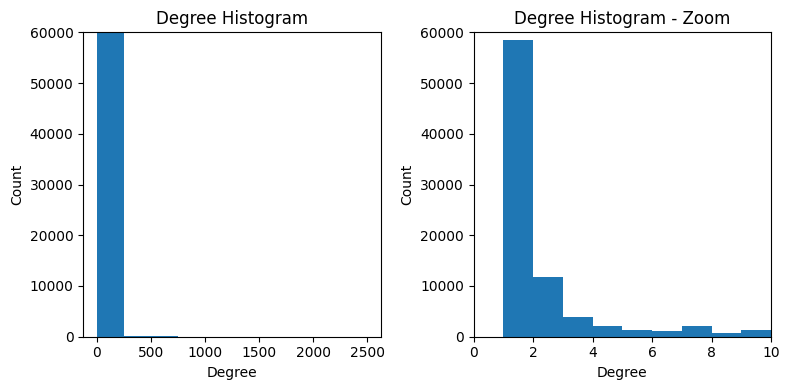

In [21]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,60000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,60000)

plt.tight_layout()
plt.show()

In [22]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 3]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "brazil_tourism2.graphml")

15610 nodes, 138883 edges


In [23]:
print("Nodes removed: {:.2f}%".format(100*(1 - 15610/85906)))
print("Edges removed: {:.2f}%".format(100*(1 - 138883/221021)))
print("Edges per nodes: {:.2f}".format(138883/15610))

Nodes removed: 81.83%
Edges removed: 37.16%
Edges per nodes: 8.90


## 1.5 Explore the network

In [29]:
top_indegree = sorted(dict(gsub.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:20]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

382 Brazil
298 Geographic Coordinate System
268 Regions Of Brazil
252 Viaf (Identifier)
219 States Of Brazil
207 Time In Brazil
197 Wayback Machine
193 Economy Of Brazil
192 Brazilian Real
190 Time Zone
181 Tourism In Brazil
174 Pantanal
173 Economic History Of Brazil
172 Central Bank Of Brazil
172 Energy Policy Of Brazil
172 Mining In Brazil
171 Industry In Brazil
171 Agriculture In Brazil
171 Corruption In Brazil
171 Transport In Brazil
